In [1]:
import sys
print sys.prefix
print sys.version

c:\anaconda2\envs\mypy
2.7.12 |Continuum Analytics, Inc.| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]


## Import custom modules and create the DrillQueries singleton

In [2]:
import aphp_waves_dic as wd
import drill_utilities as du
import drill_queries as dq

create_temp_tables = False

# drill_q = dq.DrillQueries("drill_eds", ['HR', 'RR', 'ABPS', 'ABPD', 'SPO2'])
drill_q = dq.DrillQueries("drill_eds", ['HR', 'RR', 'ABPS', 'ABPD'])

In [3]:
# drop/create temporary tables
if create_temp_tables:
    drill_q.drop_table("icu_nda_mouv_ufr_tr")
    drill_q.create_icu_nda_mouv_ufr_tr()
    drill_q.drop_table("icu_sensor_24")
    drill_q.create_icu_sensor_24()
    drill_q.drop_table("icu_nda")
    drill_q.create_icu_nda()
    drill_q.drop_table("icu_pat_info")
    drill_q.create_icu_pat_info()

In [4]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## Number of measures by type (first 24h in ICU)

In [5]:
df_mes = drill_q.drill_conn.df_from_query(drill_q.queries['QUERY_MEASURES_COUNTERS'])
df_mes['label'] = df_mes['label'].str.decode('iso-8859-1').str.encode('utf8')
df_mes.head(10)

,counter,id_measure_type,label
0,357827,10102,Frquence cardiaque
1,304973,10168,Saturation pulse Oxygne
2,297654,10120,Frequence respiratoire
3,270512,10121,Mode Ventilatoire
4,217286,11,Pression artrielle non invasive systolique
5,215712,12,Pression artrielle non invasive diastolique
6,207244,13,Pression artrielle non invasive moyenne
7,204784,10281,MEGS PAS Intervalle 2h
8,203846,10282,MEGS PAM intervalle 2h
9,203498,10283,MEGS PAD intervalle 2h


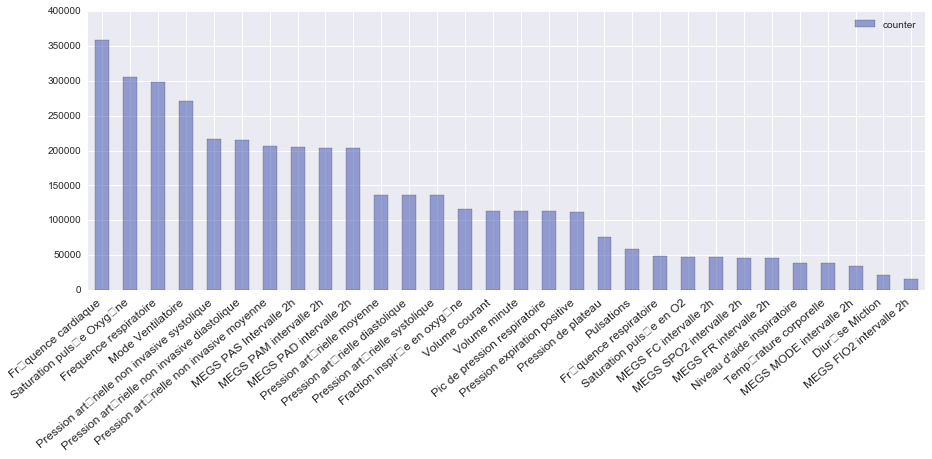

In [6]:
ax = df_mes[['counter', 'label']].head(30).plot(kind = 'bar', color = '#5566b7', alpha=0.6, figsize=(15, 5));
ax.set_xticklabels(df_mes['label'].str.decode('utf8'), rotation=40, fontsize=12, ha='right');

## sample time bounds

In [7]:
drill_q.drill_conn.df_from_query("select min(dt_deb) as begining, max(dt_deb) as ending from icu_sensor_24")

,begining,ending
0,2012-09-05,2016-09-27


## Deal with right number of points
Our aim is to be able to watch about patients staying several days in ICU (patient staying less than 20 hours are excluded because they are supposed to be out of risk once they have left the ICU).<br>
We are interested in case for which the number of points for each VOI (Variable of interest) is high enough.<br>
Lets check how many cases can be kept regarding the number minimum of points required.<br>
To work effeciently, a number of cases higher than 500 is expected<br>
For each count performed, the following filters are applied:
<ul>
<li>Each voi should hold np_pts at least;</li>
<li>Patient should have 15 or more;</li>
<li>Patient stay should be more than 20 hours</li>
</ul>

In [8]:
cases_numbers = []
for nb_pts in range(50, 301, 50):
    cases_numbers.append(len(drill_q.get_filtered_counter_matrix(nb_pts, 20)))

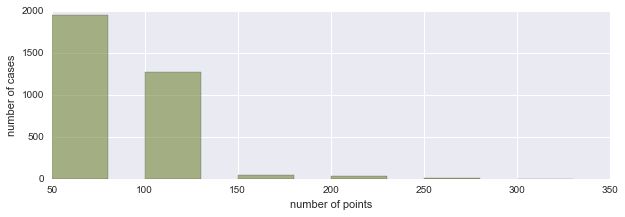

In [9]:
plt.figure(figsize=(10,3))
plt.bar(range(50, 301, 50), cases_numbers, color = '#758637', alpha=0.6, width=30);
plt.xlabel('number of points');
plt.ylabel('number of cases');

We will keep 96 at least points (about one measure by 15 minutes)

In [10]:
nb_pts = 96
counter_matrix = drill_q.get_filtered_counter_matrix(nb_pts, 20)
print "Total number of cases for first 24h on ICUs: ", len(counter_matrix)

Total number of cases for first 24h on ICUs:  1446


In [11]:
counter_matrix.head(3)

id_measure_type,11,12,14,15,10102,10120,10280,10281,10283,10285,age,pat_dt_deces,cd_sex_tr,dpt,dt_deces,dt_min,dt_max,stay_len
id_ndaj1,,,,,,,,,,,,,,,,,,
00027445892014-05-08,67.0,66.0,41.0,41.0,97.0,96.0,11.0,71.0,70.0,11.0,62.171116,2014-08-04 05:33:00,M,92.0,2014-08-04 05:33:00,2014-05-08 00:44:00,2014-05-09 00:21:01,23:37:01
00027445892014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,12.0,12.0,12.0,12.0,62.171116,2014-08-04 05:33:00,M,92.0,2014-08-04 05:33:00,2014-06-24 19:13:09,2014-06-25 18:46:02,23:32:53
00027584082014-05-12,0.0,0.0,93.0,93.0,93.0,92.0,12.0,12.0,12.0,12.0,82.800821,2015-11-17 14:40:00,M,75.0,None,2014-05-12 18:54:21,2014-05-13 17:38:01,22:43:40


## Mortality rate at this stage

In [12]:
mr = float(counter_matrix[counter_matrix['dt_deces'].notnull()].shape[0]) / float(counter_matrix.shape[0]) * 100.
print("Mortality rate: {}".format(mr))

Mortality rate: 18.6030428769


In [13]:
for v in drill_q.voi:
    aphp_codes = drill_q._dic.get_all_voi_codes([v])
    counter_matrix_v = counter_matrix[aphp_codes]
    counter_matrix[v] = counter_matrix_v.sum(axis=1)
counter_matrix.head(2)

id_measure_type,11,12,14,15,10102,10120,10280,10281,10283,10285,...,cd_sex_tr,dpt,dt_deces,dt_min,dt_max,stay_len,HR,RR,ABPS,ABPD
id_ndaj1,,,,,,,,,,,,,,,,,,,,,
00027445892014-05-08,67.0,66.0,41.0,41.0,97.0,96.0,11.0,71.0,70.0,11.0,...,M,92.0,2014-08-04 05:33:00,2014-05-08 00:44:00,2014-05-09 00:21:01,23:37:01,108.0,107.0,179.0,177.0
00027445892014-06-24,25.0,25.0,96.0,96.0,96.0,96.0,12.0,12.0,12.0,12.0,...,M,92.0,2014-08-04 05:33:00,2014-06-24 19:13:09,2014-06-25 18:46:02,23:32:53,108.0,108.0,133.0,133.0


## Number of measures per VOI and age structure of the dataset

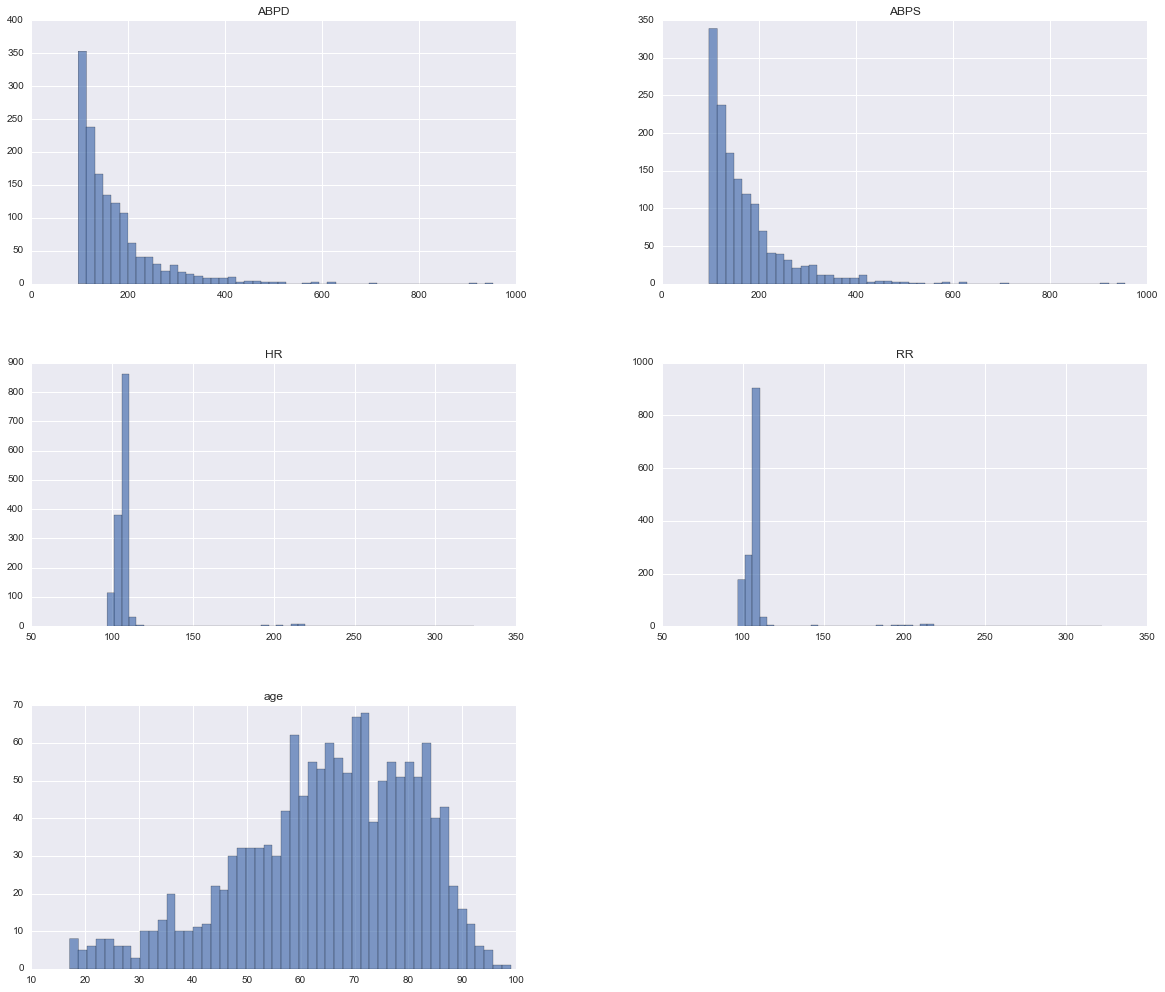

In [14]:
l = list(drill_q.voi)
l.append('age')
counter_matrix[l].hist(figsize=(20, 17), bins=50, alpha=0.7);

## Generate Parquet file from pandas DataFrame with pyspark

In [15]:
import os
spark_home = "C:\spark152"
db_path = "D:/tmp/IPYNBv2/eds"
# spark_home = "/opt/mapr/spark/spark-1.6.1"
# db_path = "/user/mapr/eds"
print(spark_home)
os.environ['SPARK_HOME'] = spark_home
os.environ['PYSPARK_DRIVER_PYTHON'] ="jupyter"
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']="notebook"
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))

C:\spark152


In [16]:
import spark_util as su
sc = su.SparkClient(spark_home, exec_memory="4g")

In [17]:
counter_matrix['id_ndaj1'] = counter_matrix.index
sc.save_nda_j1_deces_from_df(counter_matrix, db_path, drill_q.voi)

In [18]:
sc._spark_ctx.stop()

## Keep only useful measures

In [19]:
# drop/create temporary table icu_sensor_util
drill_q.drop_table("icu_sensor_util")
drill_q.create_sensor_util()

## Number of measures kept

In [20]:
list_mes = wd.np_array_2_string(drill_q._dic.get_all_voi_codes(drill_q.voi))
drill_q.drill_conn.df_from_query("select count(1) from icu_sensor_util where id_measure_type in {}".format(list_mes))

,EXPR$0
0,813737


## Load statistics per voi

In [21]:
df_stats = drill_q.get_sensor_util_stats()
df_stats.head()

,number,minimum,maximum,mean,variance,std
voi,,,,,,
RR,158823,1.0,197.0,21.352241,89.585411,9.464957
ABPS,248262,1.0,361.0,119.310076,732.250174,27.060121
HR,159720,20.0,300.0,91.722915,499.307730,22.345195
ABPD,246932,1.0,349.0,64.511003,314.288644,17.728188


## Values distributions

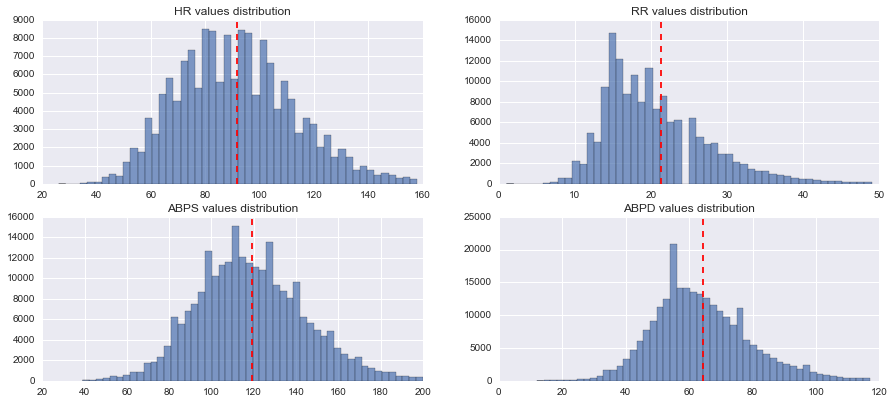

In [22]:
fig = plt.figure(figsize=(15, 10))
for i, voi in enumerate(drill_q.voi):
    mean = df_stats.loc[voi]['mean']
    # 3-sigma rule
    min_limit = drill_q._sigmas_thres[voi][0]
    max_limit = drill_q._sigmas_thres[voi][1]
    q = "select t2.voi, t1.value_numeric \
    from icu_sensor_util t1, ref_vois t2 \
    where t1.id_measure_type=t2.aphp_code \
    and t2.voi = '{}' and t1.value_numeric > {} \
    and t1.value_numeric < {}".format(voi, min_limit, max_limit)
#     print q
    df_mes = drill_q.drill_conn.df_from_query(q)
    plt.subplot(3, 2, i+1)
    plt.title(voi+" values distribution")
    df_mes['value_numeric'].hist(bins=50, alpha=0.7);
    plt.axvline(mean, color='r', linestyle='--');

In [23]:
drill_q.drop_table("map_igs2_sensor")
drill_q.create_map_igs2_sensor()

In [24]:
drill_q.nda_j1_deces_adjust()

## Age structure by class

In [19]:
import numpy as np
#
# Drillbit ODBC connection
#
conn = du.DrillODBC("drill_eds")
vois = ['HR', 'RR', 'ABPS', 'ABPD']

In [20]:
q = "select n.*, cast(round(p.age) as INT) as age from nda_j1_deces n, icu_pat_info p \
where n.id_nda = lpad(cast(p.id_nda as VARCHAR),10,'0')"
df = conn.df_from_query(q)
for v in vois:
    df[v].astype('int')
df.head(2)

print len(df)

df['outcome'] = np.where(df['dt_deces'] != 'None', 'dead', 'alive')

1446


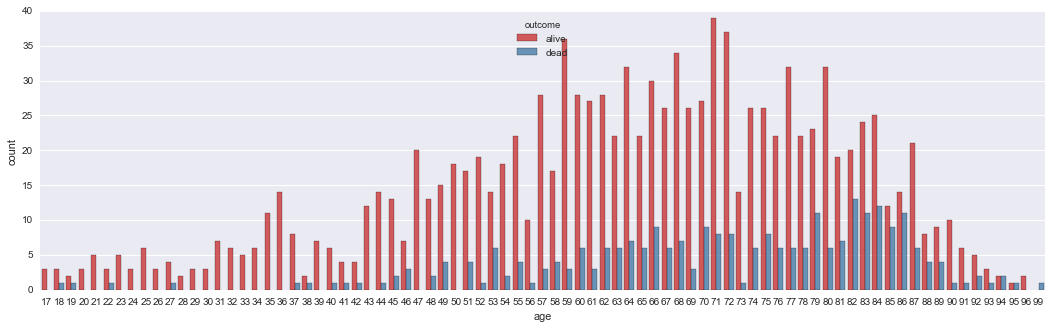

In [21]:
plt.figure(figsize=(18,5))
sns.countplot(x="age", hue="outcome", data=df, palette="Set1", alpha=0.8);